In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#enable IPython to display matplolib graphs
%matplotlib inline

from sklearn import tree


In [2]:
from ML_classes.DTModel import DTModel


2022-03-15 11:59:54.206773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 11:59:54.206789: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

max_value_energy = df["energy(kWh/hh)"].max()
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
df.sort_values('tstp', inplace=True)

In [4]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000181")
hh.pop("LCLid")
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

In [5]:
# Initiating the class
DT = DTModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 24,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [6]:
DT.DTModel()

DecisionTreeRegressor()

In [7]:
yhat = DT.predict()
yhat

[0.043525572287634415,
 0.03917301586959795,
 0.04113166577127818,
 0.032426552935205244,
 0.03438520283688547,
 0.03590859774534362,
 0.04156692400740815,
 0.03808487595436186,
 0.08248095984989436,
 0.07312296533471532,
 0.03699673603912576,
 0.09357998406668538,
 0.033079434614311364,
 0.050707293458157096,
 0.04766050201978682,
 0.03721436596791773,
 0.05505985149764751,
 0.03852013256903788,
 0.036126226052681634,
 0.04221980568651427,
 0.10837867977949886,
 0.05179543337339319,
 0.07529924192227959,
 0.05375408327507342,
 0.06789989406587285,
 0.13536453475997762,
 0.1349292781453016,
 0.06637650077886864,
 0.0726877087200393,
 0.08313384477190838,
 0.08443961137302854,
 0.118171927666446,
 0.15299238549655353,
 0.062459197732600294,
 0.12861807344703885,
 0.042872688987074345,
 0.045048968817546525,
 0.05505985149764751,
 0.045484223810768595,
 0.04004352747749604,
 0.044396085516986455,
 0.042437433993852275,
 0.042437433993852275,
 0.12361262562117253,
 0.18084875694929223,
 0

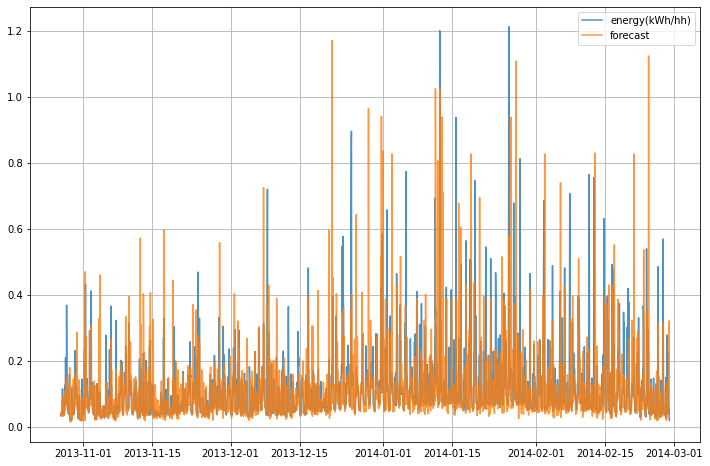

In [8]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = DT.dc.create_X_Y(ts, lag=lag_model)
X = DT.alter_x_shape(X)
# Getting the forecast
yhat = DT.model.predict(X)

yhat = DT.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_239972/276845822.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


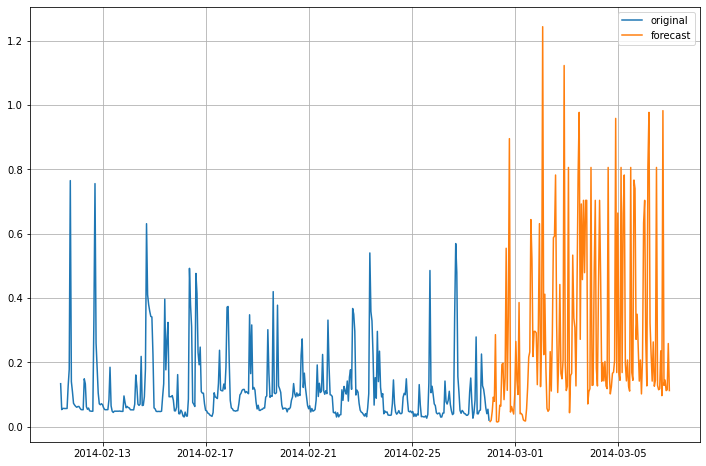

In [9]:
#Forecasting n steps ahead
n_ahead = 168
yhat = DT.predict_n_ahead(n_ahead)
yhat = [y[0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [10]:
DT.evaluateMSE()

0.014038817952936504

In [11]:
DT.evaluateRMSE()

0.11848551790382023

In [12]:
DT.evaluateMAE()

0.054983441892700574

In [13]:
DT.evaluateMAPE()

47.13142465145241

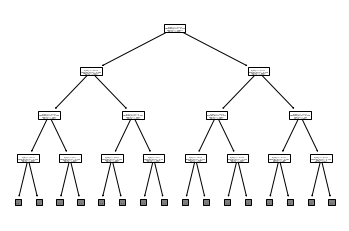

In [14]:
DT.plot_dt()